In [141]:
import pandas as pd
import numpy as np
import h5py
import folium
import vincent
import json
import matplotlib 
import matplotlib.pyplot as plt
vincent.core.initialize_notebook()

matplotlib.style.use('ggplot')
% matplotlib inline

In [142]:
working_dir = r'Q:\stefan\soundcast_runtime_test\soundcast'

# Destination 

In [143]:
# Load daysim outputs results and survey records for comparison
model = h5py.File(working_dir + r'\outputs\daysim_outputs.h5')

# Load survey data
survey = h5py.File(working_dir + r'\scripts\summarize\inputs\calibration\survey.h5')

In [144]:
def get_df(h5file, table, fields):
    '''return all fields from h5 table'''
    data = {}
    for field in fields:
        data[field] = [i for i in h5file[table][field][:]]
        
    return pd.DataFrame(data)

In [145]:
# List of columns to import
trip_fields = ['dorp','dtaz','otaz','opurp','mode','dpcl','opcl','arrtm','deptm']

survey_trip = get_df(h5file=survey, table='Trip', fields=trip_fields + ['trexpfac'])
survey_bike_trips = survey_trip[survey_trip['mode'] == 2]

model_trip = get_df(h5file=model, table='Trip', fields=trip_fields)
model_bike_trips = model_trip[model_trip['mode'] == 2]

In [146]:
# join parcel data to geography
taz_lookup = pd.read_csv(working_dir + r'\scripts\summarize\inputs\parcels_in_urbcens.csv')
district_lookup = pd.read_csv(working_dir + r'\scripts\summarize\inputs\calibration\TAZ_TAD_County.csv')

In [147]:
# Bike trips joined to destination taz
dest_survey_bike_trips = survey_bike_trips.merge(district_lookup,left_on='dtaz',right_on='TAZ')
dest_model_bike_trips = model_bike_trips.merge(district_lookup,left_on='dtaz',right_on='TAZ')

In [148]:
srv = dest_survey_bike_trips
mdl = dest_model_bike_trips
srv_name = 'Survey'
mdl_name = 'Model'

df = pd.DataFrame({srv_name: (srv.groupby('County').sum()['trexpfac']/srv.groupby('County').sum()['trexpfac'].sum())*100,
                   mdl_name: (mdl.groupby('County').count()['TAZ']/mdl.groupby('County').count()['TAZ'].sum())*100})
df

,Model,Survey
County,,
King,55.369551,74.966529
Kitsap,7.127816,1.979247
Pierce,22.404717,9.239909
Snohomish,15.097915,13.814314


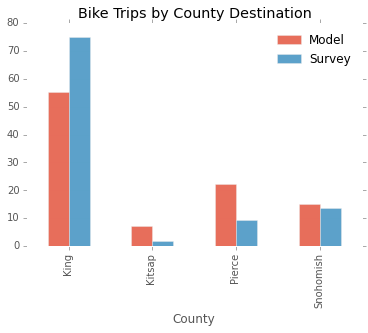

In [149]:
df.plot(kind='bar', alpha=0.8, title='Bike Trips by County Destination')

In [150]:
df = pd.DataFrame({srv_name:(srv.groupby('New DistrictName').sum()['trexpfac']/srv.groupby('New DistrictName').sum()['trexpfac'].sum())*100,
                   mdl_name: (mdl.groupby('New DistrictName').count()['TAZ']/mdl.groupby('New DistrictName').count()['TAZ'].sum())*100})
df

,Model,Survey
New DistrictName,,
East Side,13.297536,15.384569
Everett-Lynwood-Edmonds,7.412087,6.164139
Kitsap,7.127816,1.979247
North Seattle-Shoreline,10.402190,29.373744
Renton-FedWay-Kent,12.886924,3.090011
S.Kitsap,1.126553,0.040786
Seattle CBD,11.170773,17.868829
South Pierce,12.297326,3.511045
Suburban Snohomish,7.685829,7.650175


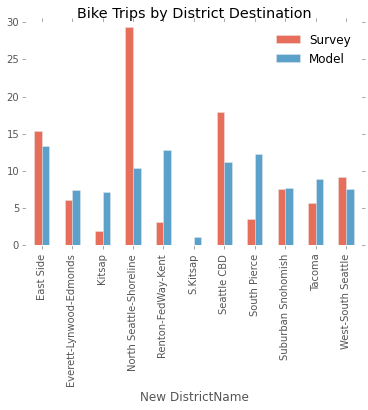

In [151]:
df[[srv_name,mdl_name]].plot(kind='bar', alpha=0.8, title='Bike Trips by District Destination')

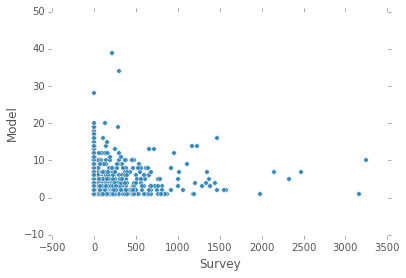

In [152]:
df = pd.DataFrame(srv.groupby('dtaz').sum()['trexpfac'])
df['taz'] = df.index

# empty df to act as base for merging trip totals by destination zone
empty = pd.DataFrame(np.zeros(3700),columns=['taz'])
empty['taz']=[i+1 for i in empty.index]
df = empty.merge(df,on='taz', how='left')
df.fillna(0,inplace=True)
df[srv_name] = df['trexpfac']
df = df[['taz',srv_name]]

# Add model trips to this df
mdl_df = pd.DataFrame(mdl.groupby('dtaz').count()['mode'])
mdl_df[mdl_name] = mdl_df['mode']
mdl_df['taz'] = mdl_df.index

df = df.merge(mdl_df,on='taz',how='left')[[srv_name,mdl_name,'taz']]
df.index= df['taz']
df = df[[srv_name,mdl_name]]

df.plot(kind='scatter', x=srv_name, y=mdl_name)

# AM Count Comparison

In [153]:
# Load count data - WSDOT 2 hour counts intersected with transRefEdges
count_intersect = pd.read_csv(working_dir + r'/inputs/bikes/bike_count_data.csv')

In [154]:
# Pick a year and time of day
count_intersect = count_intersect[count_intersect['CountYear'] == 2015]
count_intersect = count_intersect[count_intersect['CountTime'] == 'AM']

In [155]:
# Drop the intersections since there are multiple counts per line - we are only concerned about geometry here
count_intersect = count_intersect.drop_duplicates(['INode','JNode'])

In [156]:
# for new netowrk, export 'bike_count_links.csv' as an input for the bike model 
# (list of I and J node to export from the network summary)
# count_intersect[['INode','JNode','LocationID','LocationDe','CityName','CountyName']].to_csv('bike_count_links.csv', index=False)

In [157]:
model = pd.read_csv(working_dir + r'\outputs\bike_volumes.csv')

In [158]:
# Group model results by the location description to get the sum for each location
model_totals = model.groupby('LocationID').sum()[['bvol7to8','bvol8to9']]
model_totals['LocationID'] = model_totals.index

# AM counts correspond to 7 to 9 AM for WSDOT data
model_totals['AM_bvol'] = model_totals['bvol7to8']+model_totals['bvol8to9']
model_totals['model'] = model_totals['AM_bvol']

# Since we are summing up bidirectional links (mostly), divide model totals by 2
model_totals['model'] = model_totals['model']/2

In [159]:
# Group count results to get the total
# note that we're taking the min, this value should be the same for each LocationID,
# since these were intersected with a single count value
count_totals = pd.DataFrame(count_intersect.groupby('LocationID').min()['Bike_Total'])
count_totals['LocationID'] = count_totals.index
count_totals['observed'] = count_totals['Bike_Total']

In [160]:
# Join with model and count
df = pd.merge(left=model_totals[['LocationID','model']], right=count_totals[['LocationID','observed']], 
              on='LocationID',how='left')


df = pd.merge(df, count_intersect[['LocationID','LocationDe','CityName','CountyName']].drop_duplicates('LocationID'), on='LocationID',how='left')
df.index = df['LocationDe']

In [161]:
# Counts don't match up with observed link locations
list_of_missing = df[df['model'].isnull()]['LocationDe'].values

In [162]:
# Available
available_counts = df[-df['model'].isnull()]

In [163]:
# Ignore locations that have 0 counts or modeled flows - could be errors
available_counts = available_counts[(available_counts['model'] > 0) & (available_counts['observed'] > 0)]

# Point Location Results

### Seattle

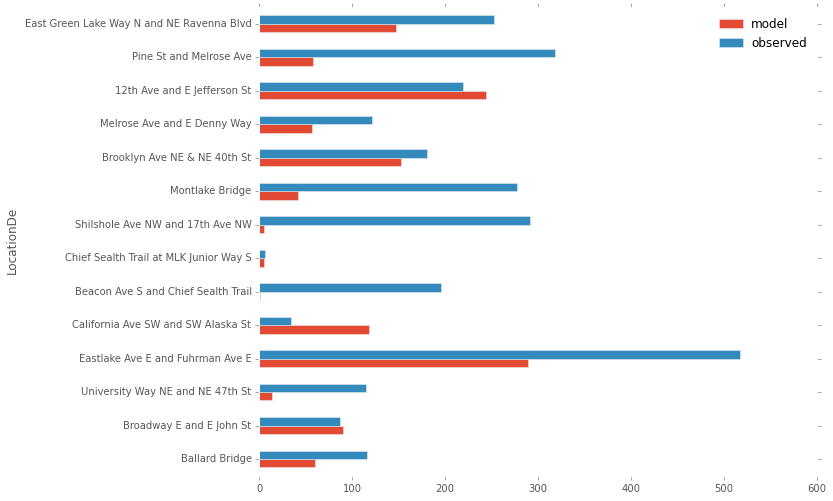

In [164]:
cityname = 'Seattle'
df = available_counts[available_counts['CityName'] == cityname]
df[['model','observed']].plot(kind='barh',figsize=(10,len(df)*.6))

### Bellevue

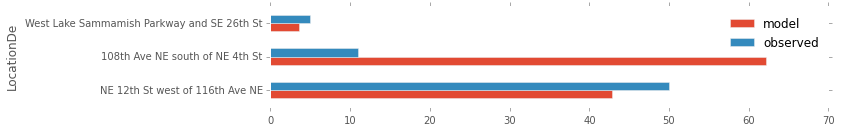

In [165]:
cityname = 'Bellevue'
df = available_counts[available_counts['CityName'] == cityname]
df[['model','observed']].plot(kind='barh',figsize=(10,len(df)*.6))

### Lakewood

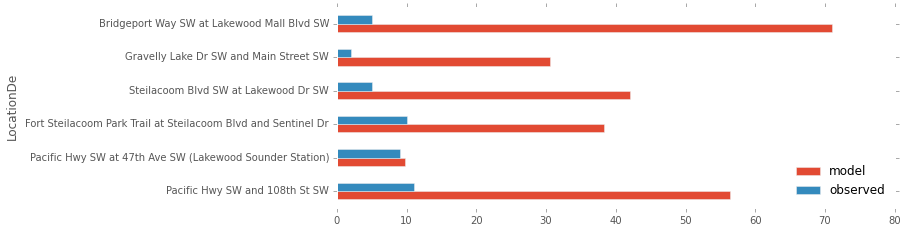

In [166]:
cityname = 'Lakewood'
df = available_counts[available_counts['CityName'] == cityname]
df[['model','observed']].plot(kind='barh',figsize=(10,len(df)*.6))

### Everett

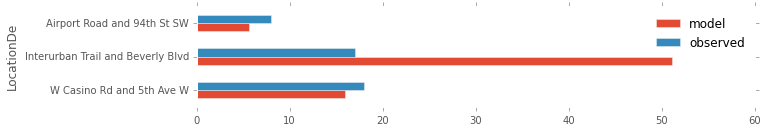

In [167]:
cityname = 'Everett'
df = available_counts[available_counts['CityName'] == cityname]
df[['model','observed']].plot(kind='barh',figsize=(10,len(df)*.6))

## By County

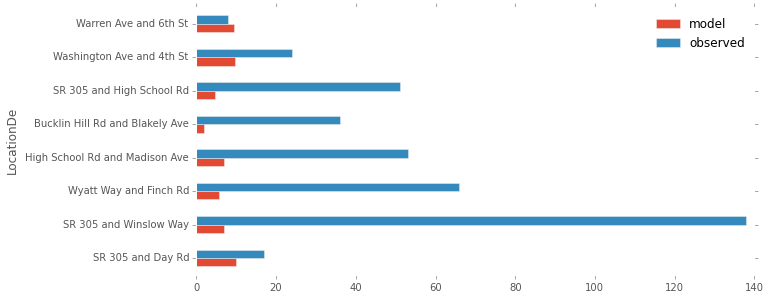

In [168]:
countyname = 'Kitsap County'
df = available_counts[available_counts['CountyName'] == countyname]
df[['model','observed']].plot(kind='barh',figsize=(10,len(df)*.6))

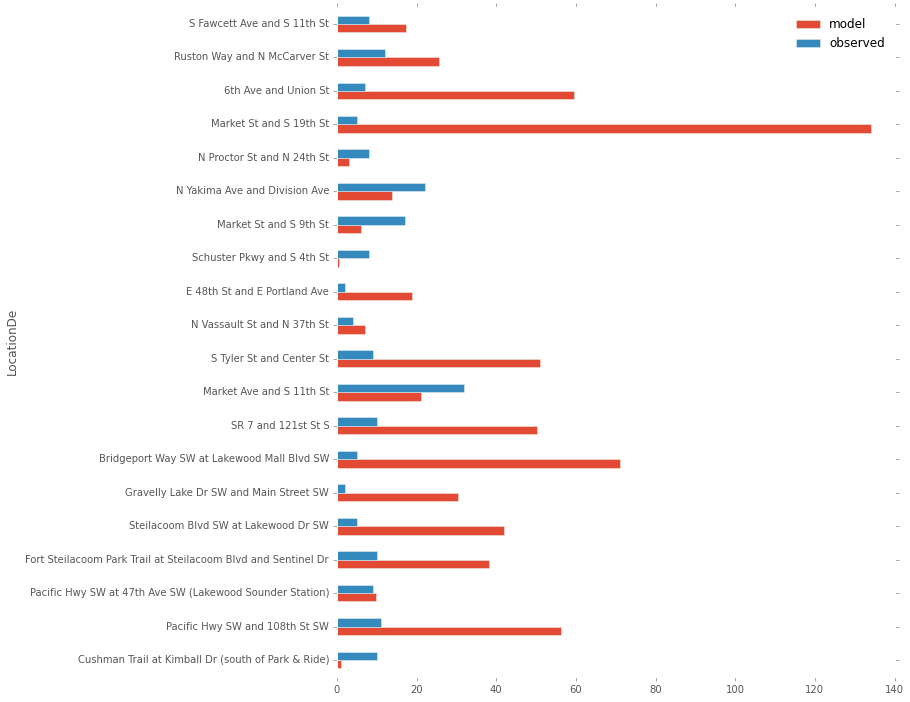

In [169]:
countyname = 'Pierce County'
df = available_counts[available_counts['CountyName'] == countyname]
df[['model','observed']].plot(kind='barh',figsize=(10,len(df)*.6))

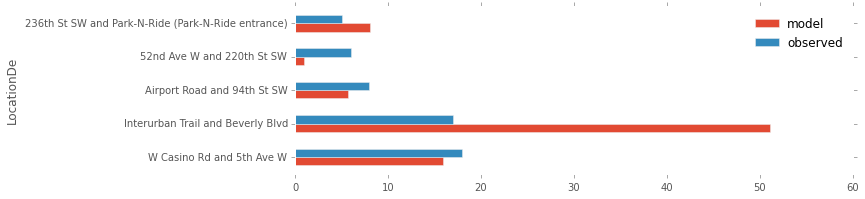

In [170]:
countyname = 'Snohomish County'
df = available_counts[available_counts['CountyName'] == countyname]
df[['model','observed']].plot(kind='barh',figsize=(10,len(df)*.6))

# Scatterplot

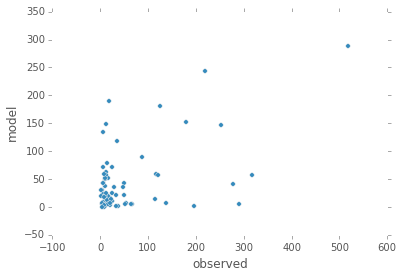

In [171]:
available_counts.plot(kind='scatter',x='observed', y='model')

In [172]:
available_counts.sort('model',ascending=False)

,LocationID,model,observed,LocationDe,CityName,CountyName
LocationDe,,,,,,
Eastlake Ave E and Fuhrman Ave E,Seattle2,288.866148,517,Eastlake Ave E and Fuhrman Ave E,Seattle,King County
12th Ave and E Jefferson St,Seattle48,244.349307,219,12th Ave and E Jefferson St,Seattle,King County
NE 116th St west of 124th Ave NE,Kirkland6,189.212400,18,NE 116th St west of 124th Ave NE,Kirkland,King County
Burke Gilman Trail west of 61st Ave NE,Kenmore5,180.699363,125,Burke Gilman Trail west of 61st Ave NE,Kenmore,King County
Brooklyn Ave NE & NE 40th St,Seattle42,152.359470,180,Brooklyn Ave NE & NE 40th St,Seattle,King County
International Blvd and Southcenter Blvd,Tukwila3,148.699243,11,International Blvd and Southcenter Blvd,Tukwila,King County
East Green Lake Way N and NE Ravenna Blvd,Seattle8,147.212572,253,East Green Lake Way N and NE Ravenna Blvd,Seattle,King County
Market St and S 19th St,Tacoma5,133.906838,5,Market St and S 19th St,Tacoma,Pierce County
California Ave SW and SW Alaska St,Seattle21,117.606444,34,California Ave SW and SW Alaska St,Seattle,King County


# Map count locations

In [173]:
df = available_counts
df = pd.merge(df,count_intersect,on='LocationID',how='left').drop_duplicates(['LocationID'])

In [174]:

df['% diff'] = (df['model']-df['observed'])/df['observed']
df['% abs diff'] = df['% diff'].abs()

In [175]:
# Show locations, with red indicating the largest differences
map_osm = folium.Map(location=[47.5836, -122.3750], zoom_start=10, tiles='Stamen Toner')

df_dict = df.to_dict(orient='records')

for i in xrange(len(df_dict)):
    color = 'green'
    lat = df_dict[i]['Latitude']
    lon = df_dict[i]['Longitude']
    diff = df_dict[i]['% abs diff']
    name = df_dict[i]['LocationDe_x']
    
    # Set color based on % difference
    color_map = plt.get_cmap('Reds')

    marker = folium.RegularPolygonMarker(location=[lat, lon], popup=name+": "+str(diff),
                   fill_color=matplotlib.colors.rgb2hex(color_map(diff)), number_of_sides=8, radius=10).add_to(map_osm)
    
    map_osm.add_children(marker);

map_osm.save('osm.html')

In [176]:
map_osm

# Skims

In [177]:
h5_7to8 = h5py.File(working_dir + r'\inputs\7to8.h5')
h5_5to6 = h5py.File(working_dir + r'\inputs\5to6.h5')
bike_skim = pd.DataFrame(h5_7to8['Skims']['mfbkpt'][:])

walk_skim = pd.DataFrame(h5_5to6['Skims']['walkt'][:])
# Convert walk time to bike time using average bike speed
walk_speed = 3.0 #mph
bike_speed = 10.0 #mph

In [178]:
# Remove external skims
walk_skim = walk_skim.ix[0:3700,0:3700]
bike_skim = bike_skim.ix[0:3700,0:3700]

walk_skim.index = [i+1 for i in walk_skim.index.values]
walk_skim.columns = walk_skim.index

bike_skim.index = [i+1 for i in bike_skim.index.values]
bike_skim.columns = bike_skim.index

In [179]:
# convert walk time to bike time (actual)
origins_walk = pd.DataFrame(walk_skim.mean()/100)*(walk_speed/bike_speed)*2
origins_walk['taz'] = origins.index
origins_walk.rename(columns={0:'bike_time'},inplace=True)

origins_bike = pd.DataFrame(bike_skim.mean()/100)
origins_bike['taz'] = origins.index
origins_bike.rename(columns={0:'perceived_bike_time'},inplace=True)

In [180]:
df = pd.merge(origins_walk,origins_bike,on='taz')
df = pd.merge(df,district_lookup,left_on='taz',right_on='TAZ')

In [181]:
df.groupby('New DistrictName').mean()[['bike_time','perceived_bike_time']]

,bike_time,perceived_bike_time
New DistrictName,,
East Side,292.290282,225.743651
Everett-Lynwood-Edmonds,297.133474,249.626341
Kitsap,381.676428,6.349976
North Seattle-Shoreline,254.990804,185.340724
Renton-FedWay-Kent,278.557638,206.987704
S.Kitsap,383.680312,11.764374
Seattle CBD,249.605690,176.017683
South Pierce,329.522528,270.071991
Suburban Snohomish,331.541165,283.870740


In [183]:
df.groupby('County').max()[['bike_time','perceived_bike_time']]

,bike_time,perceived_bike_time
County,,
King,393.034093,412.219919
Kitsap,388.655486,23.290035
Pierce,393.084927,348.125912
Snohomish,393.001098,345.371383


In [184]:
# load in upslp to edit so we can map
emme_attr = pd.read_csv(r'R:\SoundCast\Inputs\2014\bikes\emme_attr.in', sep=' ')

In [138]:
emme_attr['id'] = emme_attr['inode'].astype('str')+'-'+emme_attr['jnode'].astype('str')

In [140]:
emme_attr.to_csv(r'R://Bike/Counts/emme_attr.csv')